### A notebook that sources preprocessed data from the seafloor public bucket 

In [11]:
#need this first so TILEDB can find it
import os
os.environ['AWS_PROFILE'] = 'prod'

In [12]:
#imports
from es_sfgtools.data_mgmt.ingestion.archive_pull import load_site_metadata
from es_sfgtools.workflows.workflow_handler import WorkflowHandler
from es_sfgtools.config.env_config import Environment
import pandas as pd
from datetime import datetime, timezone, UTC

In [13]:
# set network/station/campaign and get metadata
NETWORK = "cascadia-gorda"
STATION = "GCC1"
CAMPAIGN_NAME = "2025_A_1126"

metadata = load_site_metadata(NETWORK, STATION)
metadata

Loading site metadata from https://data.earthscope.org/archive/seafloor/metadata/cascadia-gorda/GCC1.json
Loading vessel metadata from https://data.earthscope.org/archive/seafloor/metadata/vessels/1126.json
Loading vessel metadata from https://data.earthscope.org/archive/seafloor/metadata/vessels/1126.json
Loading vessel metadata from https://data.earthscope.org/archive/seafloor/metadata/vessels/1065.json
Loading vessel metadata from https://data.earthscope.org/archive/seafloor/metadata/vessels/1063.json


Site(names=['GCC1'], networks=['cascadia-gorda'], timeOrigin=datetime.datetime(2021, 10, 8, 0, 0), localGeoidHeight=0.0, arrayCenter=Location(latitude=41.6497, longitude=-125.5047, elevation=-30.9), campaigns=[Campaign(name='2025_A_1126', type='measure', vesselCode='1126', start=datetime.datetime(2025, 8, 21, 22, 23), end=datetime.datetime(2025, 8, 28, 15, 0), vessel=Vessel(name='1126', type='waveglider', model='sv3', serialNumber=None, start=datetime.datetime(2023, 2, 1, 0, 0), end=None, imuSensors=[], atdOffsets=[AtdOffset(serialNumber='641-0654', x=0.0, y=0.00053, z=0.92813)], gnssAntennas=[GnssAntenna(type='novatel', serialNumber='NMLM22110020V', start=datetime.datetime(2023, 2, 28, 0, 0), order='primary', model='GNSS-802L', radomeSerialNumber=None, end=None), GnssAntenna(type='novatel', serialNumber='NMLM22090012Z', start=datetime.datetime(2023, 2, 28, 0, 0), order='secondary', model='GNSS-802L', radomeSerialNumber=None, end=None)], gnssReceivers=[], acousticTransducers=[AcousticT

In [14]:
# print surveys for campaign from metadata
print("Surveys for campaign:", CAMPAIGN_NAME)
for campaign in metadata.campaigns:
    if campaign.name == CAMPAIGN_NAME:
        for survey in campaign.surveys:
            print("  ", survey.id, survey.start, survey.end)

Surveys for campaign: 2025_A_1126
   2025_A_1126_1 2025-08-21 22:23:00 2025-08-22 15:33:00
   2025_A_1126_2 2025-08-22 15:33:00 2025-08-28 15:00:00


In [15]:
# load the data from S3
S3_SYNC_BUCKET = "seafloor-public-bucket-bucket83908e77-6ial2vrmrawf"
WORKING_ENVIRONMENT_KEY = "GEOLAB"
MAIN_DIRECTORY_GEOLAB_KEY = "/Users/mikegottlieb/data/"
os.environ["S3_SYNC_BUCKET"] = S3_SYNC_BUCKET
os.environ["WORKING_ENVIRONMENT"] = WORKING_ENVIRONMENT_KEY
os.environ["MAIN_DIRECTORY_GEOLAB"] = MAIN_DIRECTORY_GEOLAB_KEY
env = Environment()
env.load_working_environment()
env.working_environment()


<WorkingEnvironment.GEOLAB: 'GEOLAB'>

In [16]:
workflow = WorkflowHandler()

workflow.set_network_station_campaign(
    network_id=NETWORK,
    station_id=STATION,
    campaign_id=CAMPAIGN_NAME
)

Failed to set file handler: [Errno 2] No such file or directory: '/Users/mikegottlieb/data/cascadia-gorda/GCC1/2025_A_1126/logs/es_sfg_tools.log'
Failed to set file handler: [Errno 2] No such file or directory: '/Users/mikegottlieb/data/cascadia-gorda/GCC1/2025_A_1126/logs/pride.log'
Failed to set file handler: [Errno 2] No such file or directory: '/Users/mikegottlieb/data/cascadia-gorda/GCC1/2025_A_1126/logs/processing.log'
Failed to set file handler: [Errno 2] No such file or directory: '/Users/mikegottlieb/data/cascadia-gorda/GCC1/2025_A_1126/logs/garpos.log'
Changed working station to cascadia-gorda GCC1 2025_A_1126


In [19]:
workflow.midprocess_prep_garpos(override=True) 

Network cascadia-gorda already exists.
Station GCC1 already exists in network cascadia-gorda
Campaign 2022_A_1065 already exists in station GCC1
Campaign 2023_A_1063 already exists in station GCC1
Campaign 2024_A_1126 already exists in station GCC1
Campaign 2025_A_1126 already exists in station GCC1


/Users/mikegottlieb/GIT/es_sfgtools/src/es_sfgtools/tiledb_tools/tiledb_schemas.py:45: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  py = dt.dt.to_pydatetime()  # ndarray[datetime.datetime]
/Users/mikegottlieb/GIT/es_sfgtools/src/es_sfgtools/tiledb_tools/tiledb_schemas.py:45: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  py = dt.dt.to_pydatetime()  # ndarray[datetime.datetime]
/Users/mikegottlieb/GIT/es_sfgtools/src/es_sfgtools/tiledb_tools/tiledb_schemas.py:45: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing pyt

In [20]:
#read shot data dfs from disk
def read_shotdata_file(filepath):
    return pd.read_csv(filepath, sep=",", header=0, index_col=0)

#make a plot showing the metadata and shotdata time windows from multiple surveys on the same plot
#make the lines thicker and add markers

def plot_shotdata_time_windows(station_name, metadata_time_windows, shotdata_time_windows):
    import matplotlib.pyplot as plt
    colors = ['blue', 'orange', 'red', 'green', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
    plt.figure(figsize=(10, 5))
    # use barh to plot windows
    #only show legend for first survey
    for i, survey_name in enumerate(metadata_time_windows.keys()):
        plt.barh(i-.1, metadata_time_windows[survey_name][1] - metadata_time_windows[survey_name][0], left=metadata_time_windows[survey_name][0], color=colors[0], label='Metadata' if i == 0 else "", height=0.2)
        plt.barh(i + 0.1, shotdata_time_windows[survey_name][1] - shotdata_time_windows[survey_name][0], left=shotdata_time_windows[survey_name][0], color=colors[1], label='Shotdata' if i == 0 else "", height=0.2)
    plt.ylim(-0.5, len(metadata_time_windows))
    plt.yticks(range(len(metadata_time_windows)), list(metadata_time_windows.keys()))
    plt.title(f"Survey Time Windows for Station {station_name}")
    plt.legend()
    plt.show()



2025_A_1126_1
  Metadata Start: 2025-08-21 22:23:00,       End: 2025-08-22 15:33:00
  Shotdata Start: 2025-08-21 22:23:07+00:00, End: 2025-08-22 12:49:50+00:00
2025_A_1126_2
  Metadata Start: 2025-08-22 15:33:00,       End: 2025-08-28 15:00:00
  Shotdata Start: 2025-08-22 15:36:06+00:00, End: 2025-08-28 01:53:14+00:00


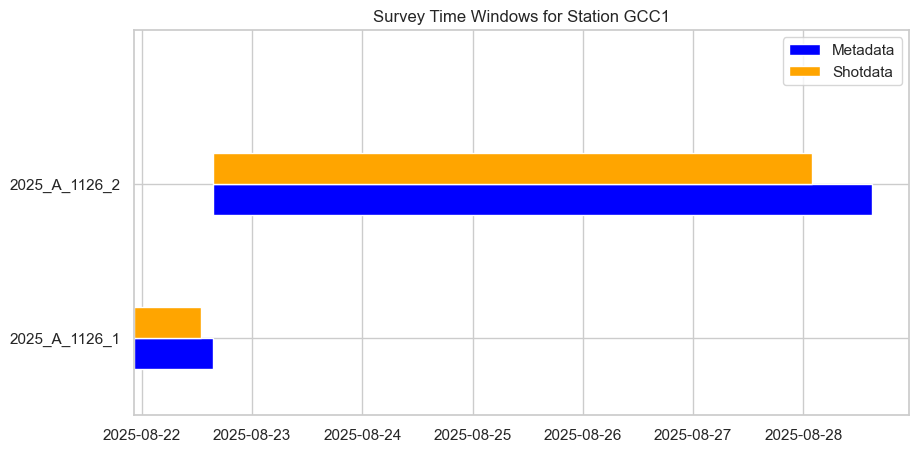

In [21]:

gh = workflow.modeling_get_garpos_handler()
gh.set_network = NETWORK
gh.set_station = STATION
gh.set_campaign = CAMPAIGN_NAME
metadata_surveys = []
for campaign in metadata.campaigns:
    if campaign.name == CAMPAIGN_NAME:
        metadata_surveys = campaign.surveys

metadata_time_windows = {}
shotdata_time_windows = {}
for survey_name in sorted(gh.current_campaign_dir.surveys):
    if survey_name in [survey.id for survey in metadata_surveys]:
        print(f"{survey_name}")
        
        for survey in metadata_surveys:
            if survey.id == survey_name:
                print(f"  Metadata Start: {survey.start},       End: {survey.end}")
                metadata_start = survey.start.replace(tzinfo=UTC)
                metadata_end = survey.end.replace(tzinfo=UTC)
                metadata_time_windows[survey_name] = (metadata_start, metadata_end)
            continue
        try:
            shotdata_filepath = gh.current_campaign_dir.surveys[survey_name].shotdata
            shotdata_df = read_shotdata_file(shotdata_filepath)
            #use utc
            start = datetime.fromtimestamp(shotdata_df['pingTime'].iloc[0], tz=timezone.utc)
            end = datetime.fromtimestamp(shotdata_df['pingTime'].iloc[-1], tz=timezone.utc)
            print(f"  Shotdata Start: {start}, End: {end}")

            shotdata_time_windows[survey_name] = (start, end)
            
        except Exception as e:
            print(e)

plot_shotdata_time_windows(STATION, metadata_time_windows, shotdata_time_windows)

In [22]:
# run garpos 
# Example custom settings for GARPOS inversion
GARPOS_CUSTOM_SETTINGS = {
    'inversion_params' : {
        'maxloop': 20 # Maximum number of inversion loops
        }
    }

SURVEY_NUMBER = 2
SURVEY_ID=f"{CAMPAIGN_NAME}_{SURVEY_NUMBER}"

RUN_ID = "1"   # Change name or number for each GARPOS run to avoid overwriting previous results

In [23]:
workflow.modeling_run_garpos(run_id=RUN_ID, 
                             survey_id=SURVEY_ID, 
                             custom_settings=GARPOS_CUSTOM_SETTINGS)

Running GARPOS model. Run ID: 1
Running GARPOS model for survey 2025_A_1126_2. Run ID: 1
Running GARPOS model for survey 2025_A_1126_2. Run ID: 1
Iteration 1 of 1 for survey 2025_A_1126_2
Running GARPOS model for GCC1, . Run ID: 0


  suffix  lamb0  lgrad  mu_t  mu_m
0     _0    1.0    0.1   0.0   0.5
Inversion loop 001, RMS(TT) =  22.510595 ms, used_shot =  91.3%, reject = 7619, Max(dX) =    10.0000, Hgt =  -3101.922
Inversion loop 002, RMS(TT) =  17.120199 ms, used_shot =  88.6%, reject = 9929, Max(dX) =    10.0000, Hgt =  -3106.545
Inversion loop 003, RMS(TT) =  12.204445 ms, used_shot =  86.8%, reject = 11551, Max(dX) =    10.0000, Hgt =  -3110.629
Inversion loop 004, RMS(TT) =   7.432620 ms, used_shot =  85.4%, reject = 12726, Max(dX) =    10.0000, Hgt =  -3114.579
Inversion loop 005, RMS(TT) =   2.132751 ms, used_shot =  84.8%, reject = 13289, Max(dX) =    10.0000, Hgt =  -3119.256
Inversion loop 006, RMS(TT) =   0.373714 ms, used_shot =  83.9%, reject = 14057, Max(dX) =     8.1474, Hgt =  -3122.139
Inversion loop 007, RMS(TT) =   0.360064 ms, used_shot =  82.7%, reject = 15115, Max(dX) =     8.7908, Hgt =  -3123.122
Inversion loop 008, RMS(TT) =   0.350535 ms, used_shot =  81.6%, reject = 16076, Max(dX) =  

Processing GARPOS results
GARPOS results processed, returning results tuple


Skipping plotting for survey 2025_A_1126_1: Run directory /Users/mikegottlieb/data/cascadia-gorda/NTH1/2025_A_1126/2025_A_1126_1/GARPOS/results/run_1 does not exist.
Using data file /Users/mikegottlieb/data/cascadia-gorda/NTH1/2025_A_1126/2025_A_1126_2/GARPOS/results/run_1/NTH1.2025_A_1126_0-res.dat for plotting.


Array Final Position: East -18.6852 m, North 36.7379 m, Up -1301.8971 m
 Sig East 0.04 m  Sig North 0.03 m  Sig Up 0.06 m 
Array Delta Position :  East -0.450 m, North 0.776 m, Up -32.672 m 
TSP M5209 : East -96.871 m, North 1012.938 m, Up -1237.041 m 
TSP M5210 : East -887.357 m, North -497.747 m, Up -1236.276 m 
TSP M5211 : East 930.871 m, North -409.632 m, Up -1236.343 m 



Saving figure to /Users/mikegottlieb/data/cascadia-gorda/NTH1/2025_A_1126/2025_A_1126_2/GARPOS/results/run_1/_1_results.png
Skipping plotting for survey 2025_A_1126_3: Run directory /Users/mikegottlieb/data/cascadia-gorda/NTH1/2025_A_1126/2025_A_1126_3/GARPOS/results/run_1 does not exist.
Skipping plotting for survey 2025_A_1126_4: Shotdata for survey 2025_A_1126_4 not found in directory handler. Please run intermediate data processing to create shotdata file.


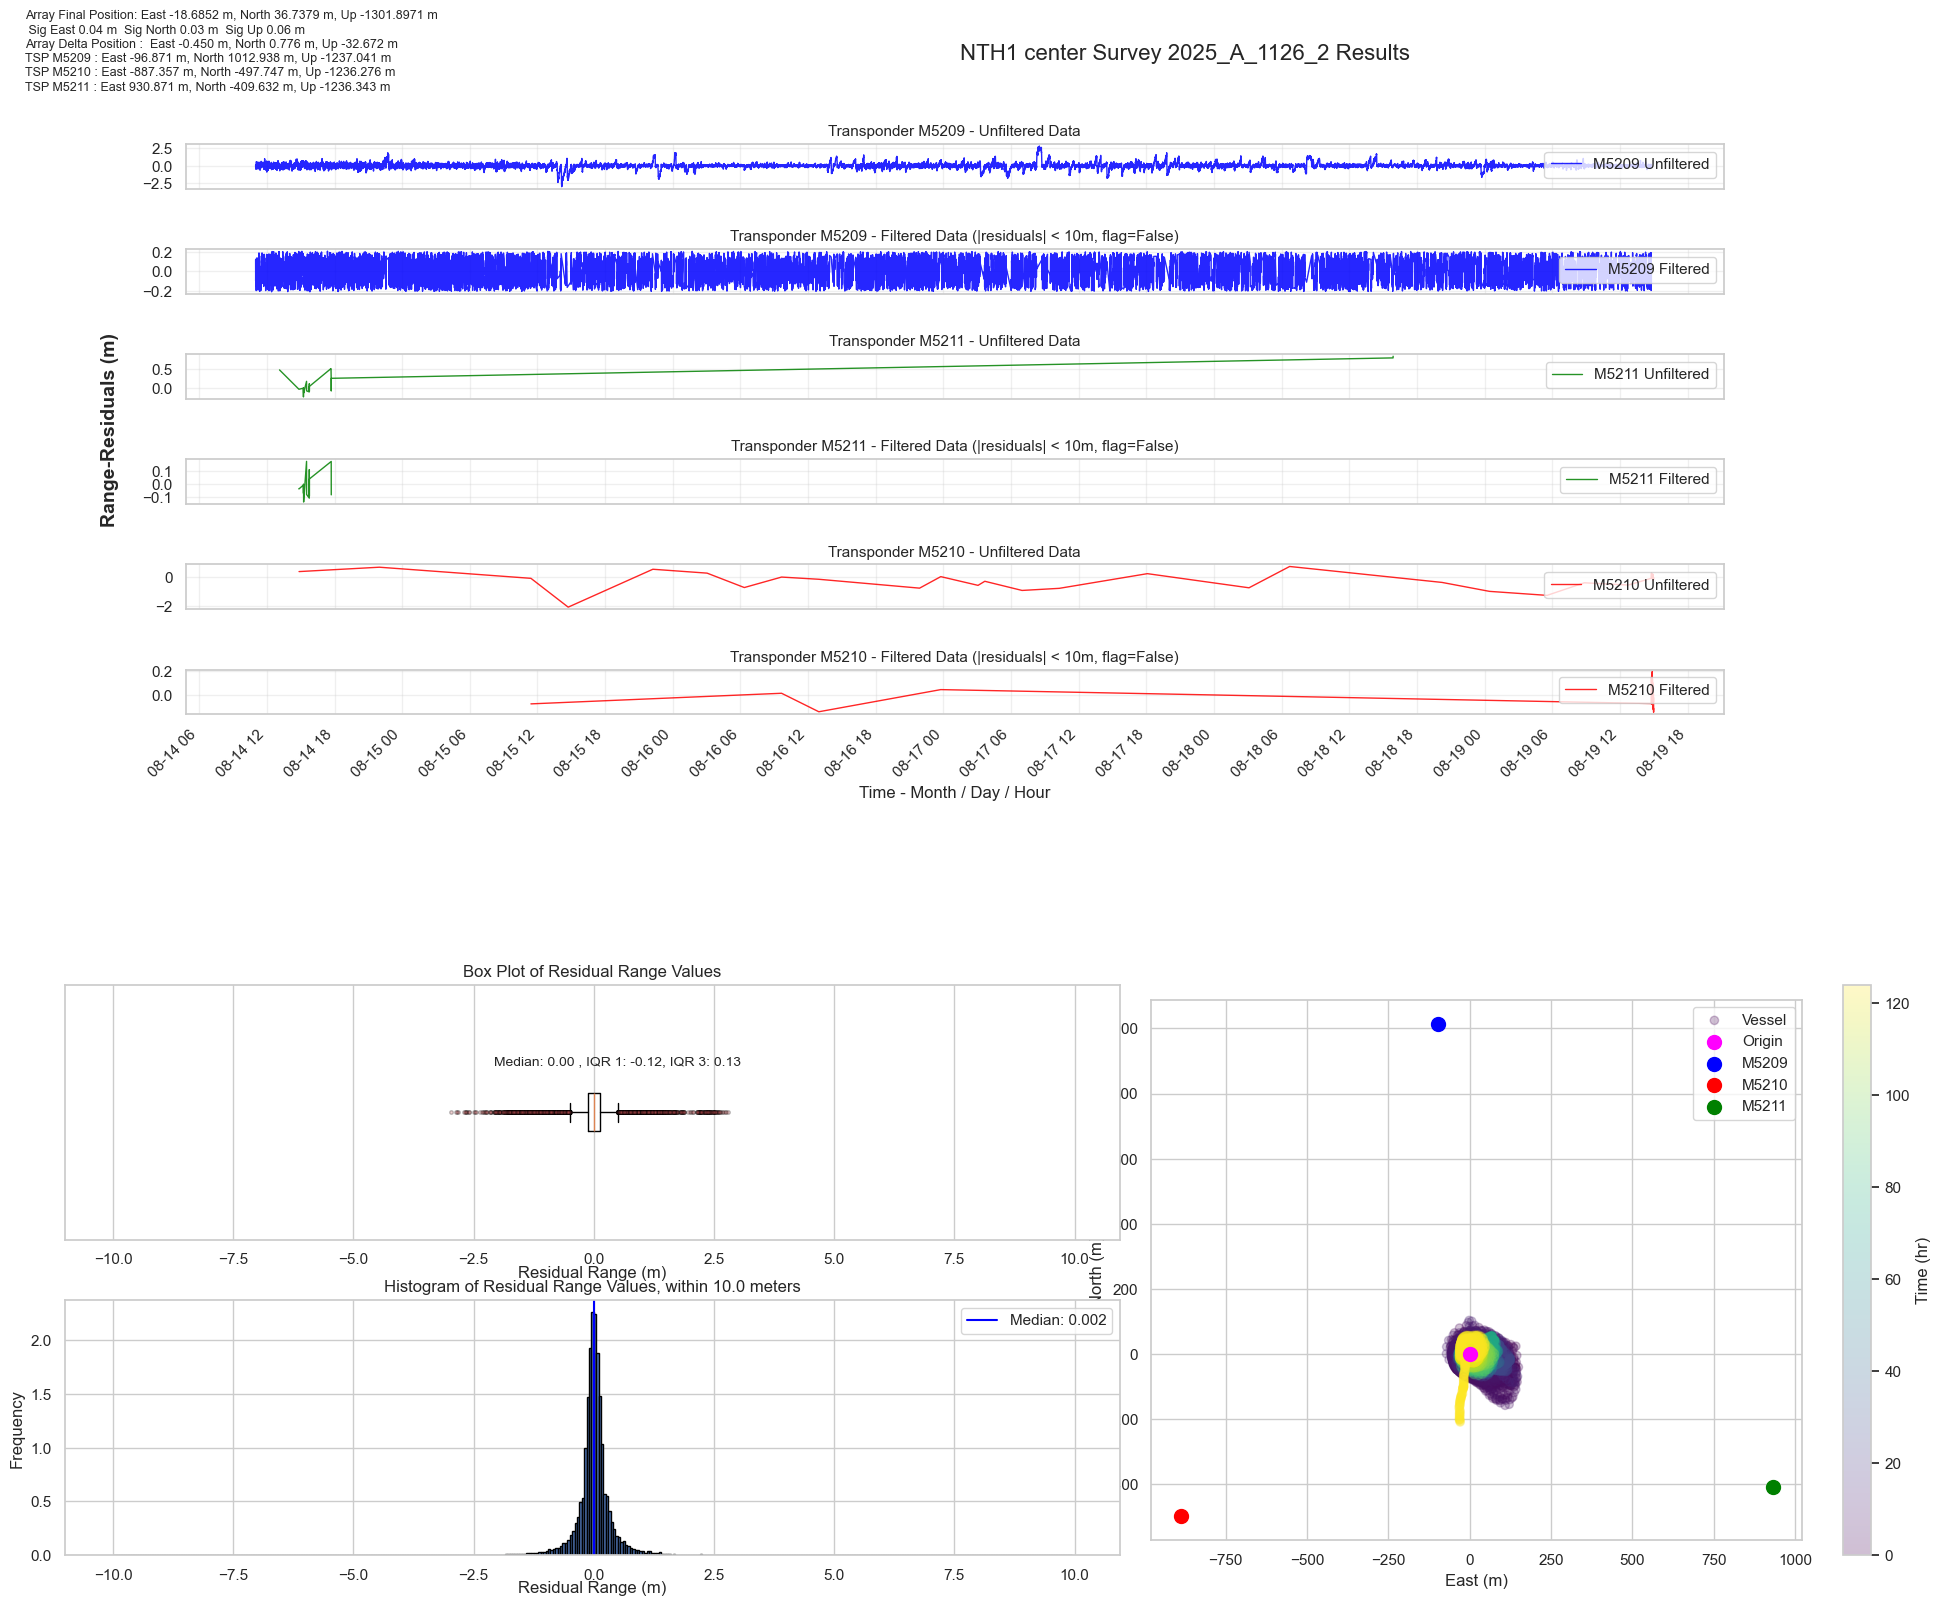

In [ ]:
workflow.modeling_plot_garpos_results(run_id=RUN_ID)